In [ ]:
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple
import colorsys
import numpy as np
import matplotlib.pyplot as plt
import sk_dsp_comm.sigsys as ss
# from nptyping import Complex128, Float64, Int64, NDArray, Shape  # type: ignore
from numpy.typing import NDArray
from scipy.signal import find_peaks
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap


 #komentra
 
 
NP1DF8 = NDArray[np.float64]
NP2DF8 = NDArray[np.float64]
NP1DC16 = NDArray[np.complex128]
NP2DC16 = NDArray[np.complex128]
TT_TYPE = NDArray[np.int64]

def filter_negWaveVectors(M_yx: NP2DC16) -> NP2DC16:
    M_kq = np.fft.fft2(M_yx)
    kLen = int(M_kq.shape[1] / 2 + 1)
    zeros = np.zeros((M_kq.shape[0], kLen))
    M_kq[:, :kLen] = zeros
    M_yx_filtered = np.fft.ifft2(M_kq)
    M_yx_filtered /= np.amax(
        np.abs(M_yx_filtered[:, int(M_yx_filtered.shape[1] / 2 + 100)])
    )
    return M_yx_filtered

def initialize_point_src() -> NP2DC16:
    M_oop = np.load("./point_source_yig/point_source_2600_MHz_200_mT_OOP.npz")["M"]
    pointSrc0 = filter_negWaveVectors(M_oop)
    return pointSrc0[:, int(pointSrc0.shape[1] / 2) :]

def generate_rectangular_function(
    distance_between_inputs: int,
    unit_cell_size: int,
    number_of_inputs: int,
    input_width: int,
    changed_src_numbers: List[int],
    input_phase_shift: float,
    active_input_amplitude: float,
) -> NP1DC16:
    d = distance_between_inputs / unit_cell_size
    s = input_width / unit_cell_size
    width = d * number_of_inputs
    x_int = np.arange(0, width, 1)
    rec = ss.rect(np.mod(x_int, d) - d / 2, s)
    
    
    g_in_an = np.zeros_like(x_int, dtype=complex)
    b = 1
    for i in range(len(x_int)):
        if rec[i] == 1 and (b in changed_src_numbers):
            phi_t = input_phase_shift
            Amp = active_input_amplitude
            if rec[i + 1] == 0:
                b += 1
        elif rec[i] == 1:
            phi_t = 0
            Amp = 1
            if rec[i + 1] == 0:
                b += 1
        else:
            phi_t = 0
            Amp = 1
        g_in_an[i] = Amp * rec[i] * np.exp(1j * phi_t)
    
    return g_in_an

def generate_layer_function(
    d: int,
    s: int,
    width: int,
    unit_cell_size: int,
    i: int,
    rect: NP1DC16,
    int_output: NP1DF8,
    phase_1d: NP1DF8,
    amplitude_modulation: bool = False,
    phase_modulation: bool = False,
) -> Tuple[NP1DF8, NP1DF8, NP1DF8, NP1DF8, NP1DF8]:
    # width = width // unit_cell_size
    x_int = np.arange(0, width, 1)
    input_amp = rect
    input_phase = np.zeros_like(x_int)
    # input_phase = np.zeros_like(x_int)
    if i>0:
        if amplitude_modulation == True and phase_modulation == False:
            input_amp = int_output
            input_phase = np.zeros_like(x_int)
        elif phase_modulation == True and amplitude_modulation == False:
            input_amp = np.array(len(x_int)*[1])
            input_phase = phase_1d
        elif amplitude_modulation == True and phase_modulation == True:
            input_amp = int_output
            input_phase = phase_1d
        else:
            input_amp = np.array(len(x_int)*[1])
            input_phase = np.zeros_like(x_int)
    # layer_func_amp = np.array(len(x_int)*[1])
    layer_func_phase = np.array(len(x_int)*[1])
    layer_func_amp = ss.rect(np.mod(x_int + (d/2)*i, d) - d/2, s)
    
    return input_amp, input_phase, layer_func_amp, layer_func_phase, x_int

def calculate_analytic_signal(
    input_amp: NP1DF8,
    input_phase: NP1DF8,
    layer_func_phase: NP1DF8,
    layer_func_amp: NP1DF8,
    x_int: NP1DF8,
    layer_func_bool: bool,
    i: int
):
    g_in_an = np.zeros_like(x_int, dtype=np.complex128)
    layer_func = np.zeros_like(x_int, dtype=np.complex128)
    
    for jj in range(len(x_int)):
        if i == 0:
            g_in_an[jj] = input_amp[jj-1] * np.exp(1j * input_phase[jj-1])
        elif i%2 == 0 and i>0 and layer_func_bool == True:
            g_in_an[jj] = input_amp[jj-1]
        elif i%2 != 0 and layer_func_bool == True and i>0:
            g_in_an[jj] = input_amp[jj-1]*layer_func_amp[jj-1] 
            # +0* np.exp(1j * (input_phase[jj-1]*layer_func_phase[jj-1]))
            layer_func[jj] = layer_func_amp[jj-1]
            # *np.exp(1j*layer_func_phase[jj-1])
        else:
            g_in_an[jj] = input_amp[jj-1] 
            # * np.exp(1j * input_phase[jj-1])
    return g_in_an, layer_func

def convolve_column(pointSrc: NP2DC16, g_in: NP1DC16, i: int) -> NP1DC16:
    return np.convolve(pointSrc[:, i], g_in, mode="full")

def convolve_columns(pointSrc: NP2DC16, g_in: NP1DC16) -> NP2DC16:
    newField = np.empty(
        (pointSrc.shape[0] + g_in.shape[0] - 1, pointSrc.shape[1]), dtype=np.complex128
    )
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(convolve_column, pointSrc, g_in, i)
            for i in range(pointSrc.shape[1])
        ]
        for i, future in enumerate(futures):
            newField[:, i] = future.result()
    return newField

def folding(arr_in, width, number_of_inputs, distance_between_inputs, unit_cell_size, input_width, j):
    yShift = -2
    y0 = int(arr_in.shape[0]/2)
    nOfFolds = int(arr_in.shape[1]/width / 2)
    a_fld = arr_in[int(y0-0.5*width-yShift):int(y0+0.5*width-yShift),:]
    for i in range(1, nOfFolds):
        tmp = arr_in[int(y0+(i-0.5)*width-yShift):int(y0+(i+0.5)*width-yShift),:]
        a_fld += tmp[::(-1)**abs(i),:]
        tmp = arr_in[int(y0+(-i-0.5)*width-yShift):int(y0+(-i+0.5)*width-yShift),:]
        a_fld += tmp[::(-1)**abs(i),:]
    return a_fld[:,:]

def slice_field(
    newField: NP2DC16,
    pointSrc: NP2DC16
) -> NP2DF8:
    newField2 = newField[:,:]
    # newField2 = newField2[int(pointSrc.shape[0]/2):-int(pointSrc.shape[0]/2),:]
    return newField2

def colourMode(mod, phase):
    mod = mod/np.amax(mod)
    array1 = np.zeros((phase.shape[0], phase.shape[1], 3))
    for y in range(phase.shape[0]):
        for x in range(phase.shape[1]):
            h = 0.5+phase[y,x]/(2*np.pi)  # angle
            l, s = (mod[y,x]), 1
            array1[y,x] = np.array(colorsys.hls_to_rgb(h, l, s))
    return array1

In [1]:
def logic_oop(
    number_of_inputs: int,
    distance_between_inputs: int,  # nm
    input_width: int,  # nm
    unit_cell_size: int,  # nm
    output_line: int,
    number_of_layers: int,
    changed_src_numbers: List[int],
    input_phase_shift: float,
    active_input_amplitude: float,
    
    plots: bool = True,
    one_d_phase: bool = False,
    layer_func_bool: bool = False,
    amplitude_modulation: bool = False,
    phase_modulation: bool = False,
    subsequent_plots: bool = False,
    ):
    intensities = []
    phases = []
    

    for j in range(number_of_layers):
        
        d = distance_between_inputs // unit_cell_size
        s = input_width // unit_cell_size
        # if j%2 == 0 and j!=0:
        width = d * number_of_inputs
        # else:
        #     width = d
    
        axhl = int(output_line // unit_cell_size)
        pointSrc: NP2DC16 = initialize_point_src()
        
        if j == 0:
            int_output = np.zeros(width)
            phase_1d = np.zeros(width)

        rect = generate_rectangular_function(distance_between_inputs, unit_cell_size, number_of_inputs,
                    input_width,
                    changed_src_numbers,
                    input_phase_shift,
                    active_input_amplitude,
                )
               
        input_amp, input_phase, layer_func_amp, layer_func_phase, x_int = generate_layer_function(
            d,
            s,
            width,
            unit_cell_size,
            j,
            rect,
            int_output,
            phase_1d,
            amplitude_modulation,
            phase_modulation,
        )        
        
        g_in_c, layer_func = calculate_analytic_signal(
            input_amp,
            input_phase,
            layer_func_phase,
            layer_func_amp,
            x_int,
            layer_func_bool,
            j
        )
        newField: NP2DC16 = convolve_columns(pointSrc, g_in_c)
        newField_fodled = folding(newField, width, number_of_inputs, distance_between_inputs, unit_cell_size, input_width, j)
        intensity: NP2DF8 = slice_field(newField_fodled, pointSrc)
        
        if j == 0:
            max_intensity = np.amax(np.abs(intensity[:,:axhl]))
        intensity /= max_intensity
        int_output: NP1DF8 = intensity[:, axhl]
        phase_2plot = np.angle(newField_fodled[:,:axhl])
        # phase_2plot = np.angle(newField_fodled[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : axhl])
        phase_1d: NP1DF8 = phase_2plot[:, -1]
        
        if plots:
            mod_2plot = np.abs(newField_fodled[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : axhl])
            intentsity_1d_x = np.arange(0, intensity.shape[0], 1)
            phase_1d_x = np.arange(0, intensity.shape[0], 1)
    
            f, ax = plt.subplots(3, 1, figsize=(8, 8))

            ax[0].plot(x_int*unit_cell_size, g_in_c, color='k')
            ax[0].fill_between(x_int*unit_cell_size, 0, g_in_c, color='#CCCCCC')
            # if np.abs(np.max(g_in_c)) > np.abs(np.min(g_in_c)):
            #     ax[0].set_ylim(-1.1*np.max(g_in_c), 1.1*np.max(g_in_c))
            # else:
            #     ax[0].set_ylim(-1.1*np.min(g_in_c), 1.1*np.min(g_in_c))
            ax[0].set_xlim(0, len(x_int)*unit_cell_size)
            ax[0].set_ylabel("Amplitude")
            if j == 0:
                ax0a = ax[0].twinx()
                ax0a.plot(x_int*unit_cell_size, np.angle(g_in_c) * 180 / np.pi, color='maroon', ls='-', lw=4)
                ax0a.tick_params(axis='y', labelcolor='maroon')
                ax0a.set_ylabel("Phase (°)", color='maroon')
                ax0a.set_ylim(-190, 190)
                ax0a.set_yticks(range(-180, 190, 90))
            
            # ax[1].imshow(colourMode(mod_2plot.T, phase_2plot.T), aspect='auto', interpolation='sinc', 
            #              extent=[0, len(intentsity_1d_x)*unit_cell_size, axhl*unit_cell_size, 0]
            #              )
            # ax[1].set_xlabel("x (nm)")
            # ax[1].set_ylabel("y (nm)")
            
            # ax[2].set_ylim(-0.5, 1)
            # ax[2].set_ylim(0, np.max(int_output)+0.1*np.max(int_output))
            ax[2].plot(intentsity_1d_x*unit_cell_size, int_output, linewidth=3, color='blue')
            ax[2].fill_between(intentsity_1d_x*unit_cell_size, 0, int_output, color='blue', alpha=0.3)
            ax[2].set_ylabel("Amplitude")
            ax[2].set_xlim(0, len(intentsity_1d_x)*unit_cell_size)
            
            ax[1].imshow(np.real(intensity).T[:axhl,:], aspect='auto', extent=[0, len(intentsity_1d_x)*unit_cell_size, axhl*unit_cell_size, 0], cmap='bwr')
            ax[1].set_xlabel("x (nm)")
            ax[1].set_ylabel("y (nm)")
            
            if one_d_phase:
                ax0b = ax[2].twinx()
                ax0b.plot(phase_1d_x*unit_cell_size, phase_1d * 180 / np.pi, linewidth=2, color='maroon')
                ax0b.set_ylabel("Phase (°)", color='maroon')
                ax0b.set_ylim(-190, 190)
                ax0b.set_yticks(range(-180, 190, 90))
                ax0b.tick_params(axis='y', labelcolor='maroon')
                
            if layer_func_bool and j>0:
                # ax0a = ax[2].twinx()
                # ax0a.plot(x_int*unit_cell_size, layer_func, color='green', ls='--', lw=2)
                # ax0a.tick_params(axis='y', labelcolor='green')
                
                ax0c = ax[0].twinx()
                ax0c.plot(x_int*unit_cell_size, layer_func, color='green', ls='--', lw=2)
                ax0c.tick_params(axis='y', labelcolor='green')
            
            plt.tight_layout()
            plt.show()
                          
        if subsequent_plots:
            # mod_2plot = np.abs(newField_fodled[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : axhl ])
            mod_2plot = np.abs(newField_fodled)
            intentsity_1d_x = np.arange(0, intensity.shape[0], 1)
            phase_1d_x = np.arange(0, intensity.shape[0], 1)
            intensities.append(intensity.T[:axhl,:])
            phases.append(colourMode(mod_2plot.T, phase_2plot.T))
        
    if subsequent_plots:
        f, axs = plt.subplots(number_of_layers, figsize=(10, 22))
        for n in range(number_of_layers):
            axs.imshow(np.real(intensities[n]), aspect='auto', cmap='bwr')
            axs.axis('off')
            # ax[n,1].imshow(phases[n], aspect='equal')
            # ax[n,1].axis('off')
            
            # if n < number_of_layers - 1:
            #     plt.axhline(y=plt.ylim()[0], color='black', lw=1)
            #     # ax[n, 1].axhline(y=ax[n, 1].get_ylim()[0], color='black', lw=1)
            
            plt.subplots_adjust(wspace=.1, hspace=0)
            # plt.plot([0.13,0.9], [(n+1)/(number_of_layers-2)-0.5, (n+1)/(number_of_layers-2)-0.5], color='lightgreen', lw=5,transform=plt.gcf().transFigure, clip_on=False)

NameError: name 'List' is not defined

In [2]:
logic_oop(
    number_of_inputs = 9,
    distance_between_inputs= 2*240,  # nm
    input_width=240,  # nm
    unit_cell_size = 15, # nm
    output_line = 33*240, # nm
    number_of_layers = 1,
    changed_src_numbers = [1,6,7],
    input_phase_shift = 0,
    active_input_amplitude = 0,
    plots = True,
    one_d_phase = False,
    layer_func_bool = True,
    amplitude_modulation = True,
    phase_modulation = False,
    subsequent_plots = True
)

NameError: name 'logic_oop' is not defined

(50, 1500)


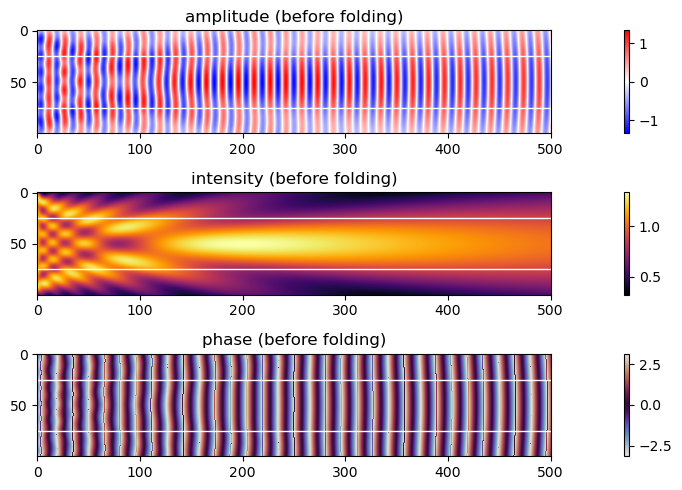

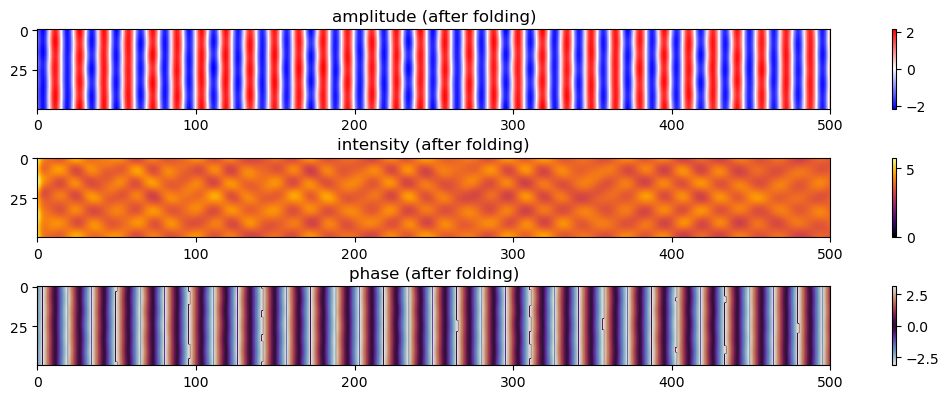

In [3]:
def initialize_point_src():
    M_oop = np.load("./point_source_yig/point_source_2600_MHz_200_mT_OOP.npz")["M"]
    pointSrc0 = M_oop
    return pointSrc0[:, int(pointSrc0.shape[1] / 2) :]

def convolve_column(pointSrc, g_in, i: int):
    return np.convolve(pointSrc[:, i], g_in, mode="full")

def convolve_columns(pointSrc, g_in):
    newField = np.empty(
        (pointSrc.shape[0] + g_in.shape[0] - 1, pointSrc.shape[1]), dtype=np.complex128
    )
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(convolve_column, pointSrc, g_in, i)
            for i in range(pointSrc.shape[1])
        ]
        for i, future in enumerate(futures):
            newField[:, i] = future.result()
    return newField

def calculate_analytic_signal(x_int):
    g_in_an = np.zeros_like(x_int, dtype=np.complex128)
    g_in = 1
    for i in range(len(x_int)-1):
        g_in_an[i] = 1 * np.exp(1j * 0)
    return g_in_an

def slice_field(newField, pointSrc):
    newField2 = np.real(newField[:,:400])
    newField2 = newField2[
        int(pointSrc.shape[0]/2):-int(pointSrc.shape[0]/2),:
        ]
    return newField2

width = 100
x_int = np.arange(0, width, 1)
pointSrc = initialize_point_src()
g_in_c = calculate_analytic_signal(x_int)
newField = convolve_columns(pointSrc, g_in_c)
intensity = slice_field(newField, pointSrc)

#----------------------------------------------------------------------
yShift = -2
arr_in = newField
W0 = 50
x0 = 0
vMax = 0.9

y0 = int(arr_in.shape[0]/2)
# a_fld = np.zeros((W0, arr_in.shape[1])).astype(np.complex128)

nOfFolds = int(arr_in.shape[0]/W0 / 2)

i = 0
a_fld = arr_in[int(y0+(i-0.5)*W0-yShift):int(y0+(i+0.5)*W0-yShift),:].copy()
sh = a_fld.shape
vMax = 0.9
xLim = 500

plt.figure(figsize=(15, 5))
plt.subplot(311)
plt.imshow(np.real(arr_in[int(y0-0.5*width-yShift):int(y0+0.5*width-yShift),x0:]), cmap="bwr", aspect="equal")
plt.axhline(y=width/2+W0/2, color='w', lw=1)
plt.axhline(y=width/2-W0/2, color='w', lw=1)
plt.xlim(0, xLim)
plt.colorbar()
plt.title("amplitude (before folding)")

plt.subplot(312)
plt.imshow(np.abs(arr_in[int(y0-0.5*width-yShift):int(y0+0.5*width-yShift),x0:]), cmap="inferno", aspect="equal")
plt.axhline(y=width/2+W0/2, color='w', lw=1)
plt.axhline(y=width/2-W0/2, color='w', lw=1)
plt.xlim(0, xLim)
plt.colorbar()
plt.title("intensity (before folding)")

plt.subplot(313)
plt.imshow(np.angle(arr_in[int(y0-0.5*width-yShift):int(y0+0.5*width-yShift),x0:]), cmap="twilight", aspect="equal")
plt.axhline(y=width/2+W0/2, color='w', lw=1)
plt.axhline(y=width/2-W0/2, color='w', lw=1)
plt.xlim(0, xLim)
plt.colorbar()
plt.title("phase (before folding)")

plt.tight_layout()

for i in range(1, nOfFolds):
    tmp = arr_in[int(y0+(i-0.5)*W0-yShift):int(y0+(i+0.5)*W0-yShift),:].copy()
    a_fld += tmp[::(-1)**abs(i),:]
    tmp = arr_in[int(y0+(-i-0.5)*W0-yShift):int(y0+(-i+0.5)*W0-yShift),:].copy()
    a_fld += tmp[::(-1)**abs(i),:]
   
print(a_fld.shape) 

plt.figure(figsize=(13, 4))

plt.subplot(311)
plt.imshow(np.real(a_fld[:,x0:]), cmap="bwr", aspect="equal")
plt.xlim(0, xLim)
plt.title("amplitude (after folding)")
plt.colorbar()

plt.subplot(312)
plt.imshow(np.abs(a_fld[:,x0:])**2, cmap="inferno", aspect="equal",vmin=0)
plt.xlim(0, xLim)
plt.title("intensity (after folding)")
plt.colorbar()

plt.subplot(313)
plt.imshow(np.angle(a_fld[:,x0:]), cmap="twilight", aspect="equal")
plt.xlim(0, xLim)
plt.title("phase (after folding)")
plt.colorbar()

plt.tight_layout()

In [2]:
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple
import colorsys
import numpy as np
import matplotlib.pyplot as plt
import sk_dsp_comm.sigsys as ss
# from nptyping import Complex128, Float64, Int64, NDArray, Shape  # type: ignore
from numpy.typing import NDArray
from scipy.signal import find_peaks
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

NP1DF8 = NDArray[np.float64]
NP2DF8 = NDArray[np.float64]
NP1DC16 = NDArray[np.complex128]
NP2DC16 = NDArray[np.complex128]
TT_TYPE = NDArray[np.int64]

def filter_negWaveVectors(M_yx: NP2DC16) -> NP2DC16:
    M_kq = np.fft.fft2(M_yx)
    kLen = int(M_kq.shape[1] / 2 + 1)
    zeros = np.zeros((M_kq.shape[0], kLen))
    M_kq[:, :kLen] = zeros
    M_yx_filtered = np.fft.ifft2(M_kq)
    M_yx_filtered /= np.amax(
        np.abs(M_yx_filtered[:, int(M_yx_filtered.shape[1] / 2 + 100)])
    )
    return M_yx_filtered

def initialize_point_src() -> NP2DC16:
    M_oop = np.load("./point_source_yig/point_source_2600_MHz_200_mT_OOP.npz")["M"]
    pointSrc0 = filter_negWaveVectors(M_oop)
    return pointSrc0[:, int(pointSrc0.shape[1] / 2) :]

def generate_rectangular_function(
    distance_between_inputs: int,
    unit_cell_size: int,
    number_of_inputs: int,
    input_width: int,
    changed_src_numbers: List[int],
    input_phase_shift: float,
    active_input_amplitude: float,
) -> NP1DC16:
    d = distance_between_inputs / unit_cell_size
    s = input_width / unit_cell_size
    width = d * number_of_inputs
    x_int = np.arange(0, width, 1)
    rec = ss.rect(np.mod(x_int, d) - d / 2, s)
    
    
    g_in_an = np.zeros_like(x_int, dtype=complex)
    b = 1
    for i in range(len(x_int)):
        if rec[i] == 1 and (b in changed_src_numbers):
            phi_t = input_phase_shift
            Amp = active_input_amplitude
            if rec[i + 1] == 0:
                b += 1
        elif rec[i] == 1:
            phi_t = 0
            Amp = 1
            if rec[i + 1] == 0:
                b += 1
        else:
            phi_t = 0
            Amp = 1
        g_in_an[i] = Amp * rec[i] * np.exp(1j * phi_t)
    
    return g_in_an

def generate_layer_function(
    d: int,
    s: int,
    width: int,
    unit_cell_size: int,
    i: int,
    rect: NP1DC16,
    int_output: NP1DF8,
    phase_1d: NP1DF8,
    amplitude_modulation: bool = False,
    phase_modulation: bool = False,
) -> Tuple[NP1DF8, NP1DF8, NP1DF8, NP1DF8, NP1DF8]:
    # width = width // unit_cell_size
    x_int = np.arange(0, width, 1)
    input_amp = rect
    input_phase = np.zeros_like(x_int)
    # input_phase = np.zeros_like(x_int)
    if i>0:
        if amplitude_modulation == True and phase_modulation == False:
            input_amp = int_output
            input_phase = np.zeros_like(x_int)
        elif phase_modulation == True and amplitude_modulation == False:
            input_amp = np.array(len(x_int)*[1])
            input_phase = phase_1d
        elif amplitude_modulation == True and phase_modulation == True:
            input_amp = int_output
            input_phase = phase_1d
        else:
            input_amp = np.array(len(x_int)*[1])
            input_phase = np.zeros_like(x_int)
    # layer_func_amp = np.array(len(x_int)*[1])
    layer_func_phase = np.array(len(x_int)*[1])
    layer_func_amp = ss.rect(np.mod(x_int + (d/2)*i, d) - d/2, s)
    
    return input_amp, input_phase, layer_func_amp, layer_func_phase, x_int

def calculate_analytic_signal(
    input_amp: NP1DF8,
    input_phase: NP1DF8,
    layer_func_phase: NP1DF8,
    layer_func_amp: NP1DF8,
    x_int: NP1DF8,
    layer_func_bool: bool,
    i: int
):
    g_in_an = np.zeros_like(x_int, dtype=np.complex128)
    layer_func = np.zeros_like(x_int, dtype=np.complex128)
    
    for jj in range(len(x_int)):
        if i == 0:
            g_in_an[jj] = input_amp[jj-1] * np.exp(1j * input_phase[jj-1])
        elif i%2 == 0 and i>0 and layer_func_bool == True:
            g_in_an[jj] = input_amp[jj-1]
        elif i%2 != 0 and layer_func_bool == True and i>0:
            g_in_an[jj] = input_amp[jj-1]*layer_func_amp[jj-1] 
            # +0* np.exp(1j * (input_phase[jj-1]*layer_func_phase[jj-1]))
            layer_func[jj] = layer_func_amp[jj-1]
            # *np.exp(1j*layer_func_phase[jj-1])
        else:
            g_in_an[jj] = input_amp[jj-1] 
            # * np.exp(1j * input_phase[jj-1])
    return g_in_an, layer_func

def convolve_column(pointSrc: NP2DC16, g_in: NP1DC16, i: int) -> NP1DC16:
    return np.convolve(pointSrc[:, i], g_in, mode="full")

def convolve_columns(pointSrc: NP2DC16, g_in: NP1DC16) -> NP2DC16:
    newField = np.empty(
        (pointSrc.shape[0] + g_in.shape[0] - 1, pointSrc.shape[1]), dtype=np.complex128
    )
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(convolve_column, pointSrc, g_in, i)
            for i in range(pointSrc.shape[1])
        ]
        for i, future in enumerate(futures):
            newField[:, i] = future.result()
    return newField

def folding(arr_in, width):
    yShift = -2
    y0 = int(arr_in.shape[0]/2)
    nOfFolds = int(arr_in.shape[1]/width / 2)
    a_fld = arr_in[int(y0-0.5*width-yShift):int(y0+0.5*width-yShift),:]
    for i in range(1, nOfFolds):
        tmp = arr_in[int(y0+(i-0.5)*width-yShift):int(y0+(i+0.5)*width-yShift),:]
        a_fld += tmp[::(-1)**abs(i),:]
        tmp = arr_in[int(y0+(-i-0.5)*width-yShift):int(y0+(-i+0.5)*width-yShift),:]
        a_fld += tmp[::(-1)**abs(i),:]
    return a_fld[:,:]

def slice_field(
    newField: NP2DC16,
    pointSrc: NP2DC16
) -> NP2DF8:
    newField2 = newField[:,:]
    # newField2 = newField2[int(pointSrc.shape[0]/2):-int(pointSrc.shape[0]/2),:]
    return newField2

def colourMode(mod, phase):
    mod = mod/np.amax(mod)
    array1 = np.zeros((phase.shape[0], phase.shape[1], 3))
    for y in range(phase.shape[0]):
        for x in range(phase.shape[1]):
            h = 0.5+phase[y,x]/(2*np.pi)  # angle
            l, s = (mod[y,x]), 1
            array1[y,x] = np.array(colorsys.hls_to_rgb(h, l, s))
    return array1

In [4]:
def logic_oop(
    number_of_inputs: int,
    distance_between_inputs: int,  # nm
    input_width: int,  # nm
    unit_cell_size: int,  # nm
    output_line: int,
    number_of_layers: int,
    changed_src_numbers: List[int],
    input_phase_shift: float,
    active_input_amplitude: float,
    
    plots: bool = True,
    one_d_phase: bool = False,
    layer_func_bool: bool = False,
    amplitude_modulation: bool = False,
    phase_modulation: bool = False,
    subsequent_plots: bool = False,
    ):
    intensities = []
    phases = []
    

    for j in range(number_of_layers):
        
        d = distance_between_inputs // unit_cell_size
        s = input_width // unit_cell_size
        # if j%2 == 0 and j!=0:
        width = d * number_of_inputs
        # else:
        #     width = d
    
        axhl = int(output_line // unit_cell_size)
        pointSrc: NP2DC16 = initialize_point_src()
        
        if j == 0:
            int_output = np.zeros(width)
            phase_1d = np.zeros(width)

        rect = generate_rectangular_function(distance_between_inputs, unit_cell_size, number_of_inputs,
                    input_width,
                    changed_src_numbers,
                    input_phase_shift,
                    active_input_amplitude,
                )
               
        input_amp, input_phase, layer_func_amp, layer_func_phase, x_int = generate_layer_function(
            d,
            s,
            width,
            unit_cell_size,
            j,
            rect,
            int_output,
            phase_1d,
            amplitude_modulation,
            phase_modulation,
        )        
        
        g_in_c, layer_func = calculate_analytic_signal(
            input_amp,
            input_phase,
            layer_func_phase,
            layer_func_amp,
            x_int,
            layer_func_bool,
            j
        )
        newField: NP2DC16 = convolve_columns(pointSrc, g_in_c)
        newField_fodled = folding(newField, width, number_of_inputs, distance_between_inputs, unit_cell_size, input_width, j)
        intensity: NP2DF8 = slice_field(newField_fodled, pointSrc)
        
        if j == 0:
            max_intensity = np.amax(np.abs(intensity[:,:axhl]))
        intensity /= max_intensity
        int_output: NP1DF8 = intensity[:, axhl]
        phase_2plot = np.angle(newField_fodled[:,:axhl])
        # phase_2plot = np.angle(newField_fodled[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : axhl])
        phase_1d: NP1DF8 = phase_2plot[:, -1]
        
        if plots:
            mod_2plot = np.abs(newField_fodled[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : axhl])
            intentsity_1d_x = np.arange(0, intensity.shape[0], 1)
            phase_1d_x = np.arange(0, intensity.shape[0], 1)
    
            f, ax = plt.subplots(3, 1, figsize=(8, 8))

            ax[0].plot(x_int*unit_cell_size, g_in_c, color='k')
            ax[0].fill_between(x_int*unit_cell_size, 0, g_in_c, color='#CCCCCC')
            # if np.abs(np.max(g_in_c)) > np.abs(np.min(g_in_c)):
            #     ax[0].set_ylim(-1.1*np.max(g_in_c), 1.1*np.max(g_in_c))
            # else:
            #     ax[0].set_ylim(-1.1*np.min(g_in_c), 1.1*np.min(g_in_c))
            ax[0].set_xlim(0, len(x_int)*unit_cell_size)
            ax[0].set_ylabel("Amplitude")
            if j == 0:
                ax0a = ax[0].twinx()
                ax0a.plot(x_int*unit_cell_size, np.angle(g_in_c) * 180 / np.pi, color='maroon', ls='-', lw=4)
                ax0a.tick_params(axis='y', labelcolor='maroon')
                ax0a.set_ylabel("Phase (°)", color='maroon')
                ax0a.set_ylim(-190, 190)
                ax0a.set_yticks(range(-180, 190, 90))
            
            # ax[1].imshow(colourMode(mod_2plot.T, phase_2plot.T), aspect='auto', interpolation='sinc', 
            #              extent=[0, len(intentsity_1d_x)*unit_cell_size, axhl*unit_cell_size, 0]
            #              )
            # ax[1].set_xlabel("x (nm)")
            # ax[1].set_ylabel("y (nm)")
            
            # ax[2].set_ylim(-0.5, 1)
            # ax[2].set_ylim(0, np.max(int_output)+0.1*np.max(int_output))
            ax[2].plot(intentsity_1d_x*unit_cell_size, int_output, linewidth=3, color='blue')
            ax[2].fill_between(intentsity_1d_x*unit_cell_size, 0, int_output, color='blue', alpha=0.3)
            ax[2].set_ylabel("Amplitude")
            ax[2].set_xlim(0, len(intentsity_1d_x)*unit_cell_size)
            
            ax[1].imshow(np.real(intensity).T[:axhl,:], aspect='auto', extent=[0, len(intentsity_1d_x)*unit_cell_size, axhl*unit_cell_size, 0], cmap='bwr')
            ax[1].set_xlabel("x (nm)")
            ax[1].set_ylabel("y (nm)")
            
            if one_d_phase:
                ax0b = ax[2].twinx()
                ax0b.plot(phase_1d_x*unit_cell_size, phase_1d * 180 / np.pi, linewidth=2, color='maroon')
                ax0b.set_ylabel("Phase (°)", color='maroon')
                ax0b.set_ylim(-190, 190)
                ax0b.set_yticks(range(-180, 190, 90))
                ax0b.tick_params(axis='y', labelcolor='maroon')
                
            if layer_func_bool and j>0:
                # ax0a = ax[2].twinx()
                # ax0a.plot(x_int*unit_cell_size, layer_func, color='green', ls='--', lw=2)
                # ax0a.tick_params(axis='y', labelcolor='green')
                
                ax0c = ax[0].twinx()
                ax0c.plot(x_int*unit_cell_size, layer_func, color='green', ls='--', lw=2)
                ax0c.tick_params(axis='y', labelcolor='green')
            
            plt.tight_layout()
            plt.show()
                          
        if subsequent_plots:
            # mod_2plot = np.abs(newField_fodled[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : axhl ])
            mod_2plot = np.abs(newField_fodled)
            intentsity_1d_x = np.arange(0, intensity.shape[0], 1)
            phase_1d_x = np.arange(0, intensity.shape[0], 1)
            intensities.append(intensity.T[:axhl,:])
            phases.append(colourMode(mod_2plot.T, phase_2plot.T))
        
    if subsequent_plots:
        f, ax = plt.subplots(number_of_layers, figsize=(10, 22))
        for n in range(number_of_layers):
            ax[n].imshow(np.real(intensities[n]), aspect='auto', cmap='bwr')
            ax[n].axis('off')
            # ax[n,1].imshow(phases[n], aspect='equal')
            # ax[n,1].axis('off')
            
            # if n < number_of_layers - 1:
            #     plt.axhline(y=plt.ylim()[0], color='black', lw=1)
            #     # ax[n, 1].axhline(y=ax[n, 1].get_ylim()[0], color='black', lw=1)
            
            plt.subplots_adjust(wspace=.1, hspace=0)
            # plt.plot([0.13,0.9], [(n+1)/(number_of_layers-2)-0.5, (n+1)/(number_of_layers-2)-0.5], color='lightgreen', lw=5,transform=plt.gcf().transFigure, clip_on=False)

In [5]:
# from concurrent.futures import ThreadPoolExecutor
# from typing import List, Tuple
# import numpy as np
# import matplotlib.pyplot as plt
# import sk_dsp_comm.sigsys as ss

# # Function to convolve input signal with kernel
# def convolve_columns(pointSrc, g_in):
#     newField = np.empty(
#         (pointSrc.shape[0] + g_in.shape[0] - 1, pointSrc.shape[1]), dtype=np.complex128
#     )
#     with ThreadPoolExecutor() as executor:
#         futures = [
#             executor.submit(lambda i: np.convolve(pointSrc[:, i], g_in, mode="full"), i)
#             for i in range(pointSrc.shape[1])
#         ]
#         for i, future in enumerate(futures):
#             newField[:, i] = future.result()
#     return newField

# Function to apply folding within the single-mode waveguide region
# def folding(arr_in, width, number_of_inputs, distance_between_inputs, unit_cell_size, input_width):
#     yShift = -2
#     y0 = int(arr_in.shape[0] / 2)
#     nOfFolds = int(arr_in.shape[1] / width / 2)
#     a_fld = arr_in[int(y0 - 0.5 * width - yShift) : int(y0 + 0.5 * width - yShift), :]
#     for i in range(1, nOfFolds):
#         tmp = arr_in[int(y0 + (i - 0.5) * width - yShift) : int(y0 + (i + 0.5) * width - yShift), :]
#         if a_fld.shape == tmp.shape:
#             if tmp.shape[0] > 0:
#                 min_shape = min(a_fld.shape[0], tmp.shape[0])
        
#                 a_fld[:min_shape, :] += tmp[:min_shape, :][:: (-1) ** abs(i), :]
#         min_shape = min(a_fld.shape[0], tmp.shape[0])
#         a_fld[:min_shape, :] += tmp[:min_shape, :][:: (-1) ** abs(i), :]
#         tmp = arr_in[int(y0 + (-i - 0.5) * width - yShift) : int(y0 + (-i + 0.5) * width - yShift), :]
        
#         if tmp.shape[0] > 0:
#             min_shape = min(a_fld.shape[0], tmp.shape[0])
#         a_fld[:min_shape, :] += tmp[:min_shape, :][:: (-1) ** abs(i), :]
#     return a_fld[:, :]


# def folding(arr_in, width, number_of_inputs, distance_between_inputs, unit_cell_size, input_width):
#     yShift = -2
#     y0 = int(arr_in.shape[0]/2)
#     nOfFolds = int(arr_in.shape[1]/width / 2)
#     a_fld = arr_in[int(y0-0.5*width-yShift):int(y0+0.5*width-yShift),:]
#     for i in range(1, nOfFolds):
#         tmp = arr_in[int(y0+(i-0.5)*width-yShift):int(y0+(i+0.5)*width-yShift),:]
#         a_fld += tmp[::(-1)**abs(i),:]
#         tmp = arr_in[int(y0+(-i-0.5)*width-yShift):int(y0+(-i+0.5)*width-yShift),:]
#         a_fld += tmp[::(-1)**abs(i),:]
#     return a_fld[:,:]

number_of_inputs = 9
distance_between_inputs= 2*240  # nm
waveguide_width= 1200# nm
unit_cell_size = 15 # nm
output_line = 33*240 # nm
number_of_layers = 4
changed_src_numbers = [1,6,7]
input_phase_shift = 0
active_input_amplitude = 0
plots = True
one_d_phase = False
layer_func_bool = True
amplitude_modulation = True
phase_modulation = False
subsequent_plots = True

intensities = []
phases = []
pointSrc: NP2DC16 = initialize_point_src()
   
x_int = np.arange(0, waveguide_width, 1)
g_in = np.array(len(x_int)*[1])
def generate_single_mode_waveguides(pointSrc, g_in, number_of_inputs, waveguide_width, unit_cell_size, distance_between_inputs):  
    convolved_field = convolve_columns(pointSrc, g_in)
    
    folded_field = folding(convolved_field[:, :], waveguide_width)
    
    for i in range(number_of_inputs):
        left = i * distance_between_inputs//unit_cell_size
        right = left + waveguide_width//unit_cell_size
        
        # Apply the folded field within each waveguide region
        field = folded_field[:, left:right]
    
    return field

# Function to visualize multiple single-mode waveguides
def visualize_waveguides(field):
    plt.imshow(np.abs(field), cmap='bwr', aspect='auto')
    plt.colorbar(label="Amplitude")
    plt.title("Multiple Single-Mode Waveguides with Folding Applied")
    plt.xlabel("Waveguide Index")
    plt.ylabel("Propagation Distance")
    plt.show()

# pointSrc = np.random.rand(domain_height, domain_width) + 1j * np.random.rand(domain_height, domain_width)  # Simulated source
# g_in = np.exp(-np.linspace(-2, 2, domain_width)**2)  # Example kernel

# Generate and visualize single-mode waveguides with folding
field1 = generate_single_mode_waveguides(pointSrc, g_in, number_of_inputs, waveguide_width, unit_cell_size, distance_between_inputs)
visualize_waveguides(field1)

TypeError: folding() missing 5 required positional arguments: 'number_of_inputs', 'distance_between_inputs', 'unit_cell_size', 'input_width', and 'j'